In [1]:
from pangolin import Given, d, t, I, IID, vmap, scan, sample, E, P, var, std, cov, corr, makerv, jags_code
from matplotlib import pyplot as plt
import numpy as np
np.set_printoptions(formatter={'float': '{:6.2f}'.format}) # print nicely

In [3]:
# Scan carrying a constant

def f(carry,input):
    return carry+1,d.norm(carry,input)
start = 7.0
inputs = np.arange(1,4)
x = scan(f)(start,inputs)

print('E(X)    ',E(x))
print('expected',start+np.arange(len(inputs)))
print('var(X)  ',var(x))
print('expected',1/inputs) # precision

E(X)     [  6.98   8.01   9.01]
expected [  7.00   8.00   9.00]
var(X)   [  1.09   0.46   0.33]
expected [  1.00   0.50   0.33]


In [4]:
# Gaussian random walk, uses dummy input
def f(carry,input):
    return d.norm(carry,1),carry
x = scan(f)(d.norm(0,1),np.zeros(5))

#print(jags_code(X))
print('var(x)')
print(var(x))
print('expected')
print(np.arange(1,6))

var(x)
[  1.04   1.92   2.80   3.87   5.06]
expected
[1 2 3 4 5]


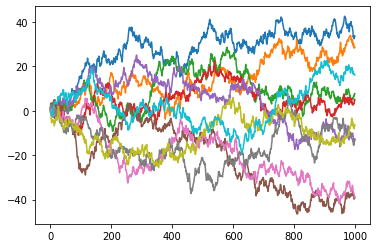

In [5]:
# samples from a Gaussian random walk

def f(carry,input):
    return d.norm(carry,1),carry
x = scan(f)(d.norm(0,1),np.zeros(1000))

# JAGS is smart enough to give you forward samples straight-away
xs = sample(x,niter=10)
plt.plot(xs.T);

In [6]:
# Deterministic scan as map

def f(carry,input):
    return 0,input**2
start = 0
inputs = np.arange(1,7)+0.0
x = scan(f)(start,inputs)

print('E(X)    ',E(x))
print('expected',inputs**2)
print('var(X)  ',var(x))
print('expected',0*inputs)

E(X)     [  1.00   4.00   9.00  16.00  25.00  36.00]
expected [  1.00   4.00   9.00  16.00  25.00  36.00]
var(X)   [  0.00   0.00   0.00   0.00   0.00   0.00]
expected [  0.00   0.00   0.00   0.00   0.00   0.00]


In [7]:
# Deterministic map-scan on vectors

def f(carry,input):
    return 0,input**2
start = 0
inputs = np.random.randn(5,2)
x = scan(f)(start,inputs)

print('E(X)    ')
print(E(x))
print('expected')
print(inputs**2)

E(X)    
[[  0.00   0.81]
 [  0.25   0.08]
 [  1.22   0.71]
 [  1.82   1.12]
 [  0.58   7.96]]
expected
[[  0.00   0.81]
 [  0.25   0.08]
 [  1.22   0.71]
 [  1.82   1.12]
 [  0.58   7.96]]


In [8]:
# Deterministic scan on vectors

def f(carry,input):
    return carry+input,(carry+input)
start = [0,0]
inputs = np.random.rand(5,2)
x = scan(f)(start,inputs)

print('E(X)    ')
print(E(x))
print('expected')
print(np.cumsum(inputs,axis=0))

E(X)    
[[  0.69   0.22]
 [  0.86   0.84]
 [  1.76   1.73]
 [  1.95   1.76]
 [  2.66   2.07]]
expected
[[  0.69   0.22]
 [  0.86   0.84]
 [  1.76   1.73]
 [  1.95   1.76]
 [  2.66   2.07]]


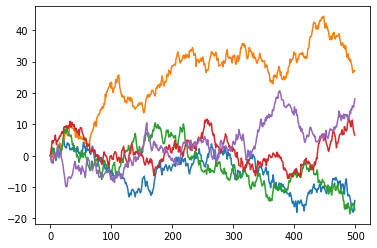

In [9]:
# Can do IID on top of scan

# Gaussian random walk
def f(carry,x):
    return d.norm(carry,1),carry

niter = 500
ntrace = 5
x = scan(f)(0,np.zeros(niter))
y = IID(x,ntrace)

ys = sample(y,niter=1)
plt.plot(ys[0].T);

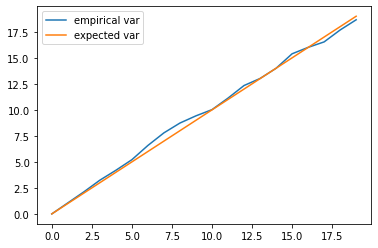

In [11]:
# IID on top of scan produces expected variance

def f(carry,x):
    return d.norm(carry,1),carry

niter = 20
ntrace = 500
x = scan(f)(0,np.zeros(niter))
y = IID(x,ntrace)

ys = sample(y,niter=1)

empirical_var = np.var(ys[0],axis=0)
expected_var = np.arange(niter) # V[x+y]=V[x]+V[y] when x⟂y

plt.plot(np.arange(niter),empirical_var,label='empirical var')
plt.plot(np.arange(niter),expected_var,label='expected var')
plt.legend();

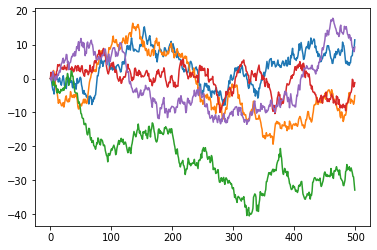

In [12]:
# scan on top of vmap also works

def diag_norm(mean):
    return vmap(d.norm)(mean,1+0*mean)

def f(carry,x):
    return diag_norm(carry), carry

ntrace = 5
niter = 500

init = np.zeros(ntrace)
y = scan(f)(init,np.zeros(niter))
 
ys = sample(y,niter=1)
plt.plot(ys[0]);


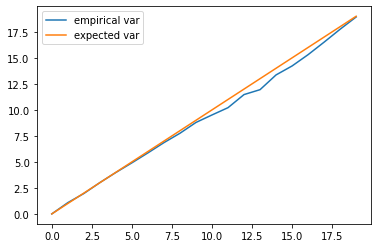

In [13]:
# scan on top of vmap gives correct variance

def diag_norm(mean):
    return vmap(d.norm)(mean,1+0*mean)

def f(carry,x):
    return diag_norm(carry), carry

ntrace = 500
niter = 20

init = np.zeros(ntrace)

y = scan(f)(init,np.zeros(niter))
 
ys = sample(y,niter=1)


empirical_var = np.var(ys[0],axis=1)
expected_var = np.arange(niter) # V[x+y]=V[x]+V[y] when x⟂y

plt.plot(np.arange(niter),empirical_var,label='empirical var')
plt.plot(np.arange(niter),expected_var,label='expected var')
plt.legend();


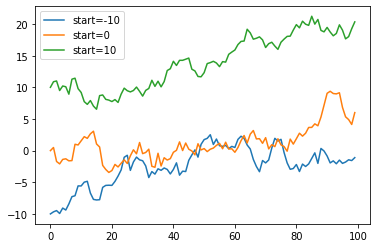

In [14]:
# vmap on top of scan, vmap over init

niter = 100

def get_walk(start):
    def f(carry,x):
        return d.norm(carry,1),carry
    return scan(f)(start,np.zeros(niter))

starts = [-10,0,10]

x = vmap(get_walk)(starts)
xs = sample(x,niter=1)

#plt.plot(xs[0].T);

for i in range(len(starts)):
    plt.plot(xs[0,i,:],label='start='+str(starts[i]))

plt.legend();


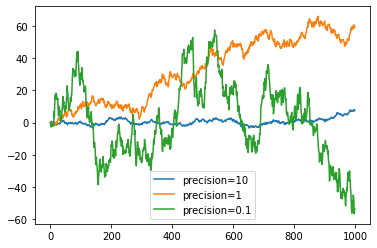

In [15]:
# vmap on top of scan, vmap over implicit value

niter = 1000

def get_walk(prec):
    def f(carry,x):
        return d.norm(carry,prec),carry
    return scan(f)(0,np.zeros(niter))

precs = [10,1,1/10]
x = vmap(get_walk)(precs)
xs = sample(x,niter=1)

for i in range(len(precs)):
    plt.plot(xs[0,i,:],label='precision='+str(precs[i]))

plt.legend();

In [17]:
# cumsum via scan

def cumsum(a):
    def f(carry,input):
        return carry+input,carry+input
    return scan(f)(0,a)

E(cumsum([1,2,3]))

array([  1.00,   3.00,   6.00])

In [18]:
# vmap on top of scan, vmap over inputs

def cumsum(a):
    def f(carry,input):
        return carry+input,carry+input
    return scan(f)(0,a)

A = np.random.randn(10,5)

x = vmap(cumsum)(A)

print('E(x)')
print(E(x))

print('expected')
print(np.cumsum(A,axis=1))

#E(cumsum(A[0]))

E(x)
[[ -0.15  -0.35  -0.47   0.94  -0.38]
 [ -0.32  -0.79  -1.12  -0.93  -0.04]
 [  0.29  -0.14  -0.36  -0.13   0.04]
 [ -0.65   1.43  -0.45  -0.88  -0.67]
 [  0.66   1.80   3.06   2.94   2.87]
 [ -0.53  -1.49  -2.86  -3.69  -4.01]
 [ -1.67  -3.37  -2.95  -4.63  -3.75]
 [  0.37   1.44   0.71   1.88   1.05]
 [ -0.16  -0.74  -0.71  -1.64  -1.30]
 [  1.14   1.64   1.17   0.96   1.52]]
expected
[[ -0.15  -0.35  -0.47   0.94  -0.38]
 [ -0.32  -0.79  -1.12  -0.93  -0.04]
 [  0.29  -0.14  -0.36  -0.13   0.04]
 [ -0.65   1.43  -0.45  -0.88  -0.67]
 [  0.66   1.80   3.06   2.94   2.87]
 [ -0.53  -1.49  -2.86  -3.69  -4.01]
 [ -1.67  -3.37  -2.95  -4.63  -3.75]
 [  0.37   1.44   0.71   1.88   1.05]
 [ -0.16  -0.74  -0.71  -1.64  -1.30]
 [  1.14   1.64   1.17   0.96   1.52]]


In [19]:
# vmap on top of scan, vmap over input as well as init

def cumsum(a,start):
    def f(carry,input):
        return carry+input,carry+input
    return scan(f)(start,a)

A = np.random.randn(10,5)
B = np.random.randn(10)

x = vmap(cumsum)(A,B)

print('E(x)')
print(E(x))

print('expected')
print(np.cumsum(A,axis=1)+np.expand_dims(B,axis=1))


E(x)
[[ -2.06  -2.28  -1.92  -1.41  -2.25]
 [  1.39  -0.97  -0.52  -1.55   0.59]
 [ -0.40   0.74   1.10   2.77   3.40]
 [ -0.84  -2.63  -4.42  -4.45  -4.94]
 [ -2.68  -1.36  -0.09  -0.66   0.02]
 [ -0.48  -0.71  -1.58  -0.00   0.25]
 [ -0.60   0.28  -0.63  -0.19   1.32]
 [  1.74   2.24   0.91   1.03  -0.50]
 [ -2.15  -3.64  -3.12  -2.53  -2.74]
 [ -0.20   0.19  -0.03  -0.43   0.38]]
expected
[[ -2.06  -2.28  -1.92  -1.41  -2.25]
 [  1.39  -0.97  -0.52  -1.55   0.59]
 [ -0.40   0.74   1.10   2.77   3.40]
 [ -0.84  -2.63  -4.42  -4.45  -4.94]
 [ -2.68  -1.36  -0.09  -0.66   0.02]
 [ -0.48  -0.71  -1.58  -0.00   0.25]
 [ -0.60   0.28  -0.63  -0.19   1.32]
 [  1.74   2.24   0.91   1.03  -0.50]
 [ -2.15  -3.64  -3.12  -2.53  -2.74]
 [ -0.20   0.19  -0.03  -0.43   0.38]]


In [20]:
# vmap on top of scan, vmap over input as well as init as well as implicit var

def cumsum(a,start,power):
    def f(carry,input):
        return (carry+input),(carry+input)**power
    return scan(f)(start,a)

A = np.random.rand(3,5)
B = np.random.rand(3)*0
power = np.random.rand(3)

x = vmap(cumsum)(A,B,power)

print('E(x)')
print(E(x))

print('expected')
print((np.cumsum(A,axis=1)+np.expand_dims(B,axis=1))**np.expand_dims(power,axis=1))

E(x)
[[  0.93   1.01   1.17   1.25   1.34]
 [  0.31   0.84   0.92   1.18   1.33]
 [  0.81   0.96   1.10   1.21   1.29]]
expected
[[  0.93   1.01   1.17   1.25   1.34]
 [  0.31   0.84   0.92   1.18   1.33]
 [  0.81   0.96   1.10   1.21   1.29]]


carry.shape ()
sadly this won't allow indexing in the natural way since mnorm is multivariate


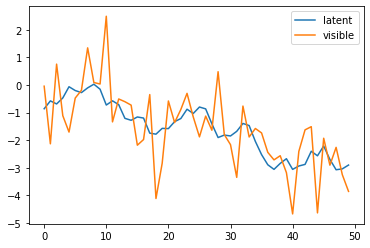

In [22]:
# hidden markov model, continuous inputs

def f(carry,input):
    print('carry.shape',carry.shape)
    output = d.mnorm(carry+[0,0],[[10,0],[0,1]])
    new_carry = output[0]
    return new_carry, output
x = scan(f)(0,np.zeros(50))
xs = sample(x,niter=1)[0]

latent = xs[:,0]
visible = xs[:,1]
plt.plot(latent,label='latent')
plt.plot(visible,label='visible');
plt.legend();

print("sadly this won't allow indexing in the natural way since mnorm is multivariate")

In [25]:
# deterministic thing

def f(carry,input):
    print('carry.shape',carry.shape)
    output = carry+[1,1.5]
    new_carry = output[0]
    return new_carry, output
x = scan(f)(0,np.zeros(8))
xs = sample(x,niter=1)[0]

print('sampled x')
print(xs)
print('expected')
print(np.vstack([np.arange(8)+1,np.arange(8)+1.5]).T)

carry.shape ()
sampled x
[[  1.00   1.50]
 [  2.00   2.50]
 [  3.00   3.50]
 [  4.00   4.50]
 [  5.00   5.50]
 [  6.00   6.50]
 [  7.00   7.50]
 [  8.00   8.50]]
expected
[[  1.00   1.50]
 [  2.00   2.50]
 [  3.00   3.50]
 [  4.00   4.50]
 [  5.00   5.50]
 [  6.00   6.50]
 [  7.00   7.50]
 [  8.00   8.50]]


In [28]:
# scan with indexing

def f(carry,input):
    output = input[1]
    new_carry = 0
    return new_carry, output
A = np.random.randn(5,2)
x = scan(f)(0,A)
xs = sample(x,niter=1)[0]

print('xs')
print(xs)
print('expected')
print(A[:,1])

xs
[ -0.04  -0.19   0.88   1.84  -1.68]
expected
[ -0.04  -0.19   0.88   1.84  -1.68]


In [29]:
# scan on top of scan

def cumsum_vec(a):
    def f(carry,input):
        return carry+input,carry+input
    return scan(f)(0,a)


def cumsum_mat(A):
    def f(carry,input):
        return carry+cumsum_vec(input),carry+cumsum_vec(input)
    start = np.zeros(A.shape[1:])
    return scan(f)(start,A)

A = np.random.randn(3,5)
x = cumsum_mat(A)

print('E(x)')
print(E(x))
print('expected')
print(np.cumsum(np.cumsum(A,axis=0),axis=1))

E(x)
[[ -0.41  -0.20  -0.74  -0.83  -0.34]
 [ -1.51  -1.56  -1.50  -2.74  -3.05]
 [ -0.57  -2.34  -2.37  -3.10  -4.23]]
expected
[[ -0.41  -0.20  -0.74  -0.83  -0.34]
 [ -1.51  -1.56  -1.50  -2.74  -3.05]
 [ -0.57  -2.34  -2.37  -3.10  -4.23]]


In [30]:
# IID on top of scan on top of scan

def cumsum_vec(a):
    def f(carry,input):
        return carry+input,carry+input
    return scan(f)(0,a)


def cumsum_mat(A):
    def f(carry,input):
        return carry+cumsum_vec(input),carry+cumsum_vec(input)
    start = np.zeros(A.shape[1:])
    return scan(f)(start,A)

A = np.random.randn(3,5)
x = cumsum_mat(A)
y = IID(x,2)

print('E(y)')
print(E(y))
print('expected')
print(np.tile(np.cumsum(np.cumsum(A,axis=0),axis=1),(2,1,1)))

E(y)
[[[ -0.17   1.19   0.55   0.97   0.82]
  [  0.16  -0.55  -1.59  -1.35  -1.54]
  [ -0.31  -1.39  -2.82  -1.95  -3.59]]

 [[ -0.17   1.19   0.55   0.97   0.82]
  [  0.16  -0.55  -1.59  -1.35  -1.54]
  [ -0.31  -1.39  -2.82  -1.95  -3.59]]]
expected
[[[ -0.17   1.19   0.55   0.97   0.82]
  [  0.16  -0.55  -1.59  -1.35  -1.54]
  [ -0.31  -1.39  -2.82  -1.95  -3.59]]

 [[ -0.17   1.19   0.55   0.97   0.82]
  [  0.16  -0.55  -1.59  -1.35  -1.54]
  [ -0.31  -1.39  -2.82  -1.95  -3.59]]]
